In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from random import choice
from matplotlib.image import BboxImage
from matplotlib.transforms import Bbox, TransformedBbox
from skimage.transform import resize
from scipy.stats import norm
import tensorflow as tf
from utils import *
#from tensorflow.contrib import layers

### Load Data list names
Rather than load all the data into ram. We just load the names of all the images and annotations. Shuffle the names and partition them into train and test sets. Then we only load the images/annotations when neeed.

In [2]:
base_dir      = '../data/clr_120_160/'
image_dir     = base_dir + 'images/'
anno_dir      = base_dir + 'annotations/'
train_path = '../data/evened_train.txt'
test_path  = '../data/evened_test.txt'
NUM_BINS = 15

raw_train = load_dataset(train_path)
raw_test = load_dataset(test_path)

# Bining Steering Data
The steering and throttle annotations come in as numbers between 0 and 1023. So our network does not need to have 1024 output neurons we partition the data into bins.

ie:

if we had data consisting of numbers 0-9 :



`data = [1,4,5,0,9,8,5,4,3,2,5,6,7]`

and we binned in lost of 2 the our data would look like this:
```
# bins:  0   1   2   3   4
# nums: 01, 23, 45, 67, 89

binned = [0,2,2,0,4,4,2,2,1,1,2,3,3]
```

## Data Generator

This is what we're going to use to take care of loading our actual images and annotations as we need them. When initalized it shuffles the `data_names` then calling the `get_next_bacth` function returns a tuple of `(images, annotations)`. Calling the `still_has_data`function returns a boolean indicating wether or not all the data has been used up.

In [3]:
from generator import DataGenerator as gen

# For training (WILL bin steering annos, and WILL normalize throttle)           
# Images are normalized                                                         
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  
from generator import preprocess_normalize_images_bin_annos as process_fn       
from generator import prepare_batch_images_and_labels_RAND_MIRROR as prep_batch 
                                                                                
# For evaluation (will NOT bin steering annos, and will leave throttle 0-1024)  
# Images are normalized                                                         
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  
#from generator import preprocess_normalize_images_only as process_fn           
#from generator import prepare_batch_images_and_labels_NO_MIRROR as prep_batch

In [4]:
train_gen=gen(batch_size=10, 
              data_set=raw_train[:100],
              image_dir=image_dir,
              anno_dir=anno_dir,
              preprocess_fn=process_fn,
              prepare_batch_fn=prep_batch)

test_gen=gen(batch_size=10, 
             data_set=raw_test[:50],
             image_dir=image_dir,
             anno_dir=anno_dir,
             preprocess_fn=process_fn,
             prepare_batch_fn=prep_batch)

Loading Data: 100%|██████████| 50/50 [00:00<00:00, 784.98it/s]


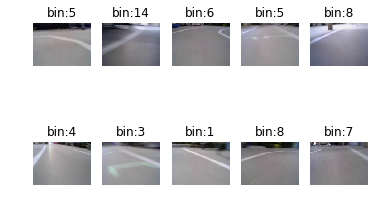

In [5]:
train_gen.reset(shuffle=False)
batch = train_gen.get_next_batch()
images   =  batch["images"]
steering = [ele["steering"] for ele in batch["annotations"]]
throttle = [ele["throttle"] for ele in batch["annotations"]]
names    = batch["names"]
for i, (im, st, th, na) in enumerate(zip(images[:10], steering[:10], throttle[:10], names[:10])):
    plot = i+1
    plt.subplot(2,5,plot)
    if np.shape(images)[3] == 1:
        plt.imshow(im[:,:,0])
    else:
        plt.imshow(im[:,:,])
    plt.axis('off')
    angle = st
    plt.title("bin:{}".format(int(angle)))



### Some hyperparams

In [6]:
from show_graph import show_graph
import tf_donkey as model
from freeze_graph import freeze_meta


train_gen.reset()
test_gen.reset()
classes = [x for x in range(NUM_BINS)]
car_brain = model.Model(in_shape=[120,160,3], classes=classes)

### Train and Test Generators

# !!!!!!!!!!!!!!!! --- Run The Model --- !!!!!!!!!!!!!!!!

In [7]:
epochs = 1
batch_size = 50
learning_rate = 0.001
return_info = car_brain.train(train_gen=train_gen,
                              test_gen=test_gen,
                              save_dir = "./__z__",
                              epochs=epochs)
               
frozen_meta = freeze_meta(return_info["graph_path"],
                                    return_info["ckpt_path"],
                                    return_info["out_path"]+"/frozen.pb",
                                    return_info["tensor_json"])
return_info["frozen_meta"] = frozen_meta

Testing: 100%|██████████| 5/5 [00:00<00:00, 21.20it/s]


--------------------------------------------------
tensor_dict: {'inputs': {'image_input': 'input:0'}, 'outputs': {'steering_prediction': 'donkey/steering_prediction:0', 'steering_probs': 'donkey/steeringi_probs:0', 'throttle_prediction': 'donkey/throttle/Sigmoid:0'}}
tensor dict saved at ./__z__/tensor_names.json
Model saved at ./__z__/ep_1.ckpt
Done, final best loss: 2.44
tensor_names: {'inputs': {'image_input': 'input:0'}, 'outputs': {'steering_prediction': 'donkey/steering_prediction:0', 'steering_probs': 'donkey/steeringi_probs:0', 'throttle_prediction': 'donkey/throttle/Sigmoid:0'}}
output_names: ['donkey/steering_prediction', 'donkey/steeringi_probs', 'donkey/throttle/Sigmoid']
INFO:tensorflow:Restoring parameters from /home/jp/Documents/FYP/ml/end2end/__z__/ep_1.ckpt
INFO:tensorflow:Froze 19 variables.
Converted 19 variables to const ops.
116 ops in the final graph.
FROZEN graph at: ./__z__/frozen.pb


In [9]:
from generator import DataGenerator as gen

# For training (WILL bin steering annos, and WILL normalize throttle)           
# Images are normalized                                                         
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  
#from generator import preprocess_normalize_images_bin_annos as process_fn       
#from generator import prepare_batch_images_and_labels_RAND_MIRROR as prep_batch 
                                                                                
# For evaluation (will NOT bin steering annos, and will leave throttle 0-1024)  
# Images are normalized                                                         
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  
from generator import preprocess_normalize_images_only as process_fn           
from generator import prepare_batch_images_and_labels_NO_MIRROR as prep_batch

base_dir      = '../data/clr_120_160/'
image_dir     = base_dir + 'images/'
anno_dir      = base_dir + 'annotations/'
test_path  = '../data/evened_test.txt'

raw_test = load_dataset(test_path)
test_gen=gen(batch_size=10, 
             data_set=raw_test[:50],
             image_dir=image_dir,
             anno_dir=anno_dir,
             preprocess_fn=process_fn,
             prepare_batch_fn=prep_batch)

Loading Data: 100%|██████████| 50/50 [00:00<00:00, 794.30it/s]


### Perform Prediction on images using ONLY test data


In [10]:
import tf_donkey as modelmodel
from load_frozen import load_graph

test_gen.reset()                                               
t_test = trange(test_gen.steps_per_epoch)                     
t_test.set_description(f": Poop")

#frozen_graph_path  = "path/to/frozen_graph.pb"
#tensor_lookup_path = "path/to/tensor_lookup.json"

frozen_graph_path = return_info["frozen_meta"]
tensor_lookup = json.load(open(return_info["tensor_json"]))

prefix = "model"
graph = load_graph(frozen_graph_path, prefix)
x_tens        = graph.get_tensor_by_name(prefix+"/"+tensor_lookup[model.INPUTS][model.IMAGE_INPUT])
steering_preds_tens = graph.get_tensor_by_name(prefix+"/"+tensor_lookup[model.OUTPUTS][model.STEERING_PREDICTION])
steering_probs_tens = graph.get_tensor_by_name(prefix+"/"+tensor_lookup[model.OUTPUTS][model.STEERING_PROBS])
throttle_tens = graph.get_tensor_by_name(prefix+"/"+tensor_lookup[model.OUTPUTS][model.THROTTLE_PREDICTION])
with tf.Session(graph=graph) as sess:

    steering = {"preds" : [], "annos" : []}
    throttle = {"preds" : [], "annos" : []}
    for step in t_test:                       
        images, st_annos, th_annos = model.prepare_data(test_gen)
        st_preds, st_probs, th_preds = sess.run([steering_preds_tens, steering_probs_tens, throttle_tens],
                                           feed_dict={x_tens: images})
        steering["annos"].extend(st_annos)
        steering["preds"].extend(st_preds*1024)
        throttle["annos"].extend(th_annos)
        throttle["preds"].extend(th_preds*1024)


: Poop: 100%|██████████| 5/5 [00:00<00:00, 16.61it/s]


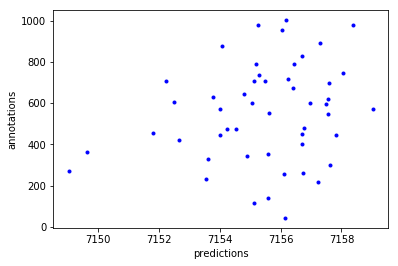

In [10]:
plt.plot(steering["preds"], steering["annos"], 'b.')
plt.xlabel("predictions")
plt.ylabel("annotations")
fig = plt.gcf()
#fig.savefig('tf_jp_clr_15bins_scatter.png', dpi=100)

# Time Series tracking

Text(0.5,0,'throttle command')

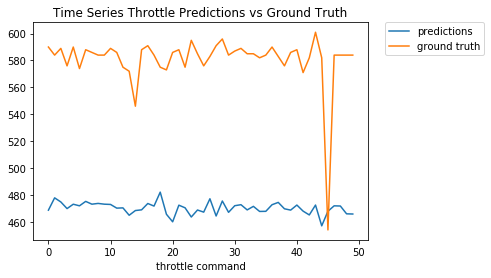

In [11]:
plt.plot(throttle["preds"], label="predictions")
plt.plot(throttle["annos"], label="ground truth")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Time Series Throttle Predictions vs Ground Truth")
plt.xlabel("time (frames)")
plt.xlabel("throttle command")

Text(0.5,0,'steering command')

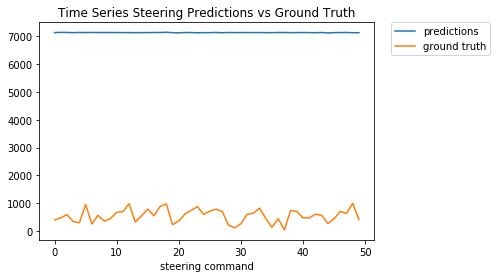

In [12]:
plt.plot(steering["preds"], label="predictions")
plt.plot(steering["annos"], label="ground truth")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Time Series Steering Predictions vs Ground Truth")
plt.xlabel("time (frames)")
plt.xlabel("steering command")